# 피마인디언 데이터 분석

## Ridge 회귀

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("pima-indians-diabetes.csv", names=["pregnant", "plasma", "pressure", "thickness", "insulin", "BMI", "pedigree", "age", "class"])

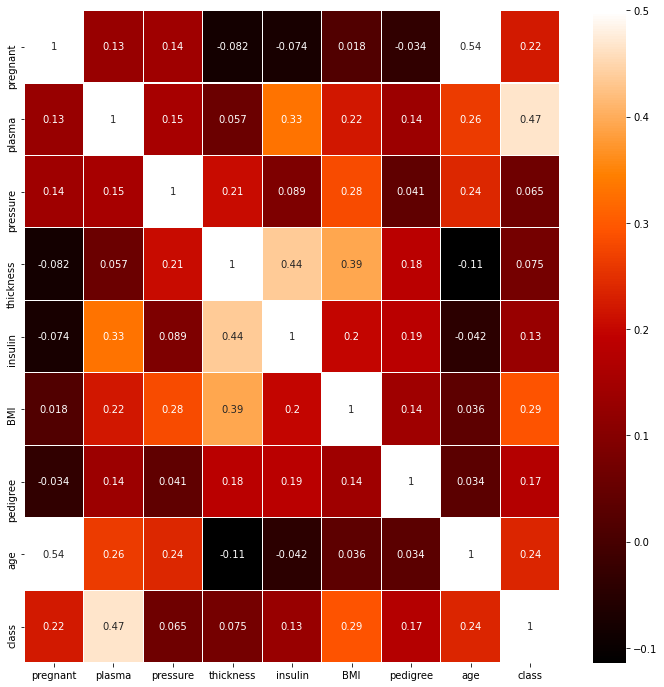

In [5]:
colormap = plt.cm.gist_heat
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), linewidths=0.1, vmax=0.5, cmap=colormap, linecolor="white", annot=True)
plt.show()

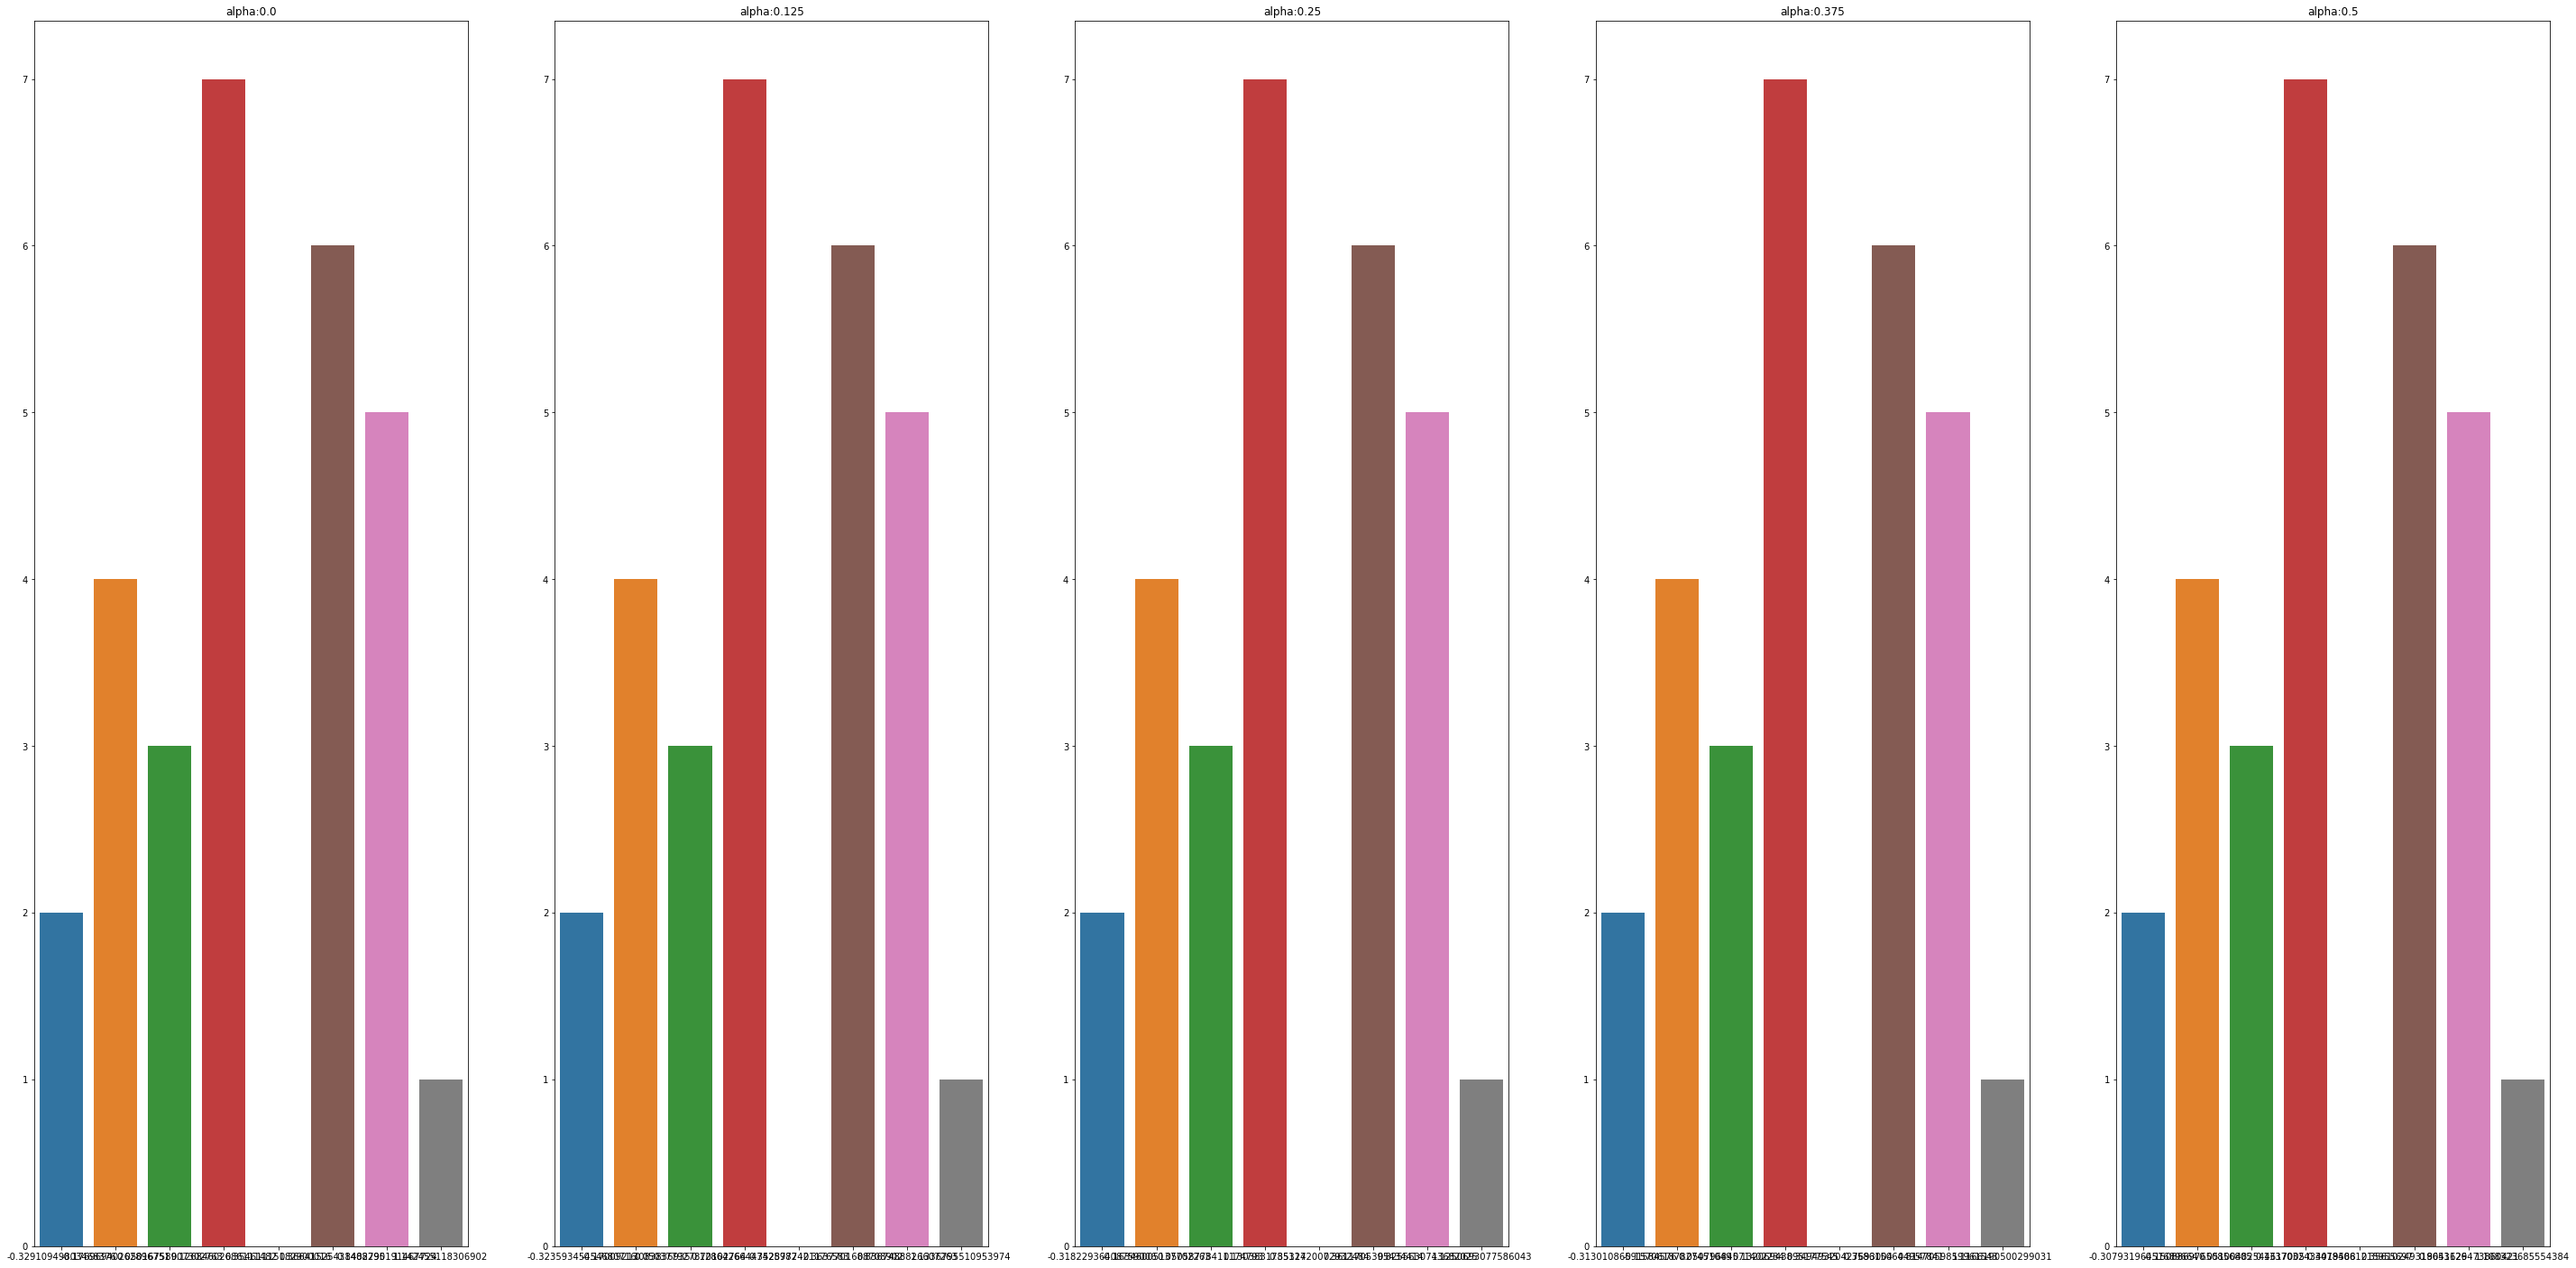

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


## 데이터 생성

x = df.iloc[:,:8]
y = df.iloc[:,8]

## feture scaling

scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.transform(x)
x = pd.DataFrame(x)


## 데이터 분리

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=121)


# Ridge
alphas = np.linspace(0, 0.5, 5)
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성  
fig , axs = plt.subplots(figsize=(50,25) , nrows=1 , ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성  
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(x_train , y_train)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.  
    coeff = pd.Series(data=ridge.coef_ , index=x_train.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-5,5)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

In [7]:
pred = ridge.predict(x_test)

print("Variance score: {0:.3f}".format(r2_score(y_test, pred)))

Variance score: 0.427


## 분류

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate


# 의사 결정 나무 객체 생성
indian_DT = DecisionTreeClassifier()
scores = cross_val_score(indian_DT, x, y, scoring="accuracy", cv=10)

print('교차 검증별 정확도:', np.round(scores, 4))
print('평균 검증 정확도:', np.round(np.mean(scores), 4))

교차 검증별 정확도: [0.6494 0.7662 0.7013 0.5974 0.6883 0.7013 0.8312 0.7922 0.6711 0.7105]
평균 검증 정확도: 0.7109


### GridSearch

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

parameters = {"max_depth":[2,3,5,10], "min_samples_split":[2,3,5], "min_samples_leaf":[1,5,8]}

grid_dtree = GridSearchCV(indian_DT, param_grid=parameters, scoring="accuracy", cv = 5)

grid_dtree.fit(x_train, y_train)

print("GridSearchCV 최적 하이퍼 파라미터: ", grid_dtree.best_params_)
print("GridSearchCV 최고 정확도: {0:.4f}".format(grid_dtree.best_score_))
best_dclf = grid_dtree.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 estimator로 예측 및 평가 수행
dpredictions = best_dclf.predict(x_test)

accuracy = accuracy_score(y_test, dpredictions)
precision = precision_score(y_test, dpredictions)
recall = recall_score(y_test, dpredictions)

print("테스트 세트에서의 DecisionTreeClassifier 정확도: {0:.4f}".format(accuracy))

GridSearchCV 최적 하이퍼 파라미터:  {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7482
테스트 세트에서의 DecisionTreeClassifier 정확도: 0.8312


# 딥러닝 모델

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy
import tensorflow as tf

# seed 값 생성
numpy.random.seed(121)
tf.random.set_seed(121)

# 데이터 로드
dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=',')

# 정규화
scalar = MinMaxScaler()
scaler.fit(dataset)
df = scaler.transform(dataset)
x = df[:,0:8]
y = df[:,8]


## 데이터 분리

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=121)

# 모델의 설정
model = Sequential()
model.add(Dense(30, input_dim=8, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation=tf.keras.layers.LeakyReLU()))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 실행
model.fit(x_train, y_train, epochs=100, batch_size=10)

# 결과 출력
print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test)[1]))

Epoch 1/100
70/70 [==============================] - 0s 1ms/step - loss: 0.6975 - accuracy: 0.5119
Epoch 2/100
70/70 [==============================] - 0s 1ms/step - loss: 0.6348 - accuracy: 0.6570
Epoch 3/100
70/70 [==============================] - 0s 1ms/step - loss: 0.6157 - accuracy: 0.6658
Epoch 4/100
70/70 [==============================] - 0s 1ms/step - loss: 0.5678 - accuracy: 0.7410
Epoch 5/100
70/70 [==============================] - 0s 1ms/step - loss: 0.5652 - accuracy: 0.7079
Epoch 6/100
70/70 [==============================] - 0s 1ms/step - loss: 0.5369 - accuracy: 0.7286
Epoch 7/100
70/70 [==============================] - 0s 1ms/step - loss: 0.5192 - accuracy: 0.7645
Epoch 8/100
70/70 [==============================] - 0s 1ms/step - loss: 0.4795 - accuracy: 0.7707
Epoch 9/100
70/70 [==============================] - 0s 1ms/step - loss: 0.5078 - accuracy: 0.7318
Epoch 10/100
70/70 [==============================] - 0s 1ms/step - loss: 0.5023 - accuracy: 0.7542
Epoch 11/

70/70 [==============================] - 0s 1ms/step - loss: 0.4568 - accuracy: 0.7866
Epoch 83/100
70/70 [==============================] - 0s 1ms/step - loss: 0.4273 - accuracy: 0.7785
Epoch 84/100
70/70 [==============================] - 0s 1ms/step - loss: 0.4072 - accuracy: 0.8130
Epoch 85/100
70/70 [==============================] - 0s 1ms/step - loss: 0.4125 - accuracy: 0.7999
Epoch 86/100
70/70 [==============================] - 0s 1ms/step - loss: 0.4587 - accuracy: 0.7586
Epoch 87/100
70/70 [==============================] - 0s 1ms/step - loss: 0.3763 - accuracy: 0.8438
Epoch 88/100
70/70 [==============================] - 0s 1ms/step - loss: 0.4200 - accuracy: 0.7956
Epoch 89/100
70/70 [==============================] - 0s 1ms/step - loss: 0.4222 - accuracy: 0.8229
Epoch 90/100
70/70 [==============================] - 0s 1ms/step - loss: 0.4298 - accuracy: 0.7880
Epoch 91/100
70/70 [==============================] - 0s 1ms/step - loss: 0.4450 - accuracy: 0.7883
Epoch 92/100


## 앙상블

In [232]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# 데이터 로드
dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=',')

# 정규화
scalar = MinMaxScaler()
scaler.fit(dataset)
df = scaler.transform(dataset)
x = df[:,0:8]
y = df[:,8]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state =121)



# 개별 모델은 로지스틱 회귀와 KNN
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=121)
rfc_clf = RandomForestClassifier(random_state=121)


# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현
vo_clf = VotingClassifier(estimators=[("LR", lr_clf), ("KNN", knn_clf), ("RFC", rfc_clf)], voting="soft")

# VotingClassifier 학습/예측/평가
vo_clf.fit(x_train, y_train)
pred = vo_clf.predict(x_test)
print("Voting 분류기 정확도: {0:.4f}".format(accuracy_score(y_test, pred)))


# 개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf, rfc_clf]
for cf in classifiers:
    cf.fit(x_train, y_train)
    pred=cf.predict(x_test)
    class_name = cf.__class__.__name__
    print("{0} 정확도: {1:.4f}".format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.8312
LogisticRegression 정확도: 0.8571
KNeighborsClassifier 정확도: 0.7532
RandomForestClassifier 정확도: 0.8182


## EXTRA

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
import numpy
import tensorflow as tf

# seed 값 생성
numpy.random.seed(121)
tf.random.set_seed(121)

# 데이터 로드
dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=',')

# 정규화
scalar = MinMaxScaler()
scaler.fit(dataset)
df = scaler.transform(dataset)
x = df[:,0:8]
y = df[:,8]


# 모델의 설정

def create_model():
    model = Sequential()
    model.add(Dense(30, input_dim=8, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # 모델 컴파일
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 모델 실행
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

scores = cross_val_score(model, x, y, scoring="accuracy", cv=10)

scores.mean()